# Projeto de filtro FIR por método das janelas

### Diagrama de blocos:

![imagem_1.jpeg](imagens/imagem_1.jpeg)


### Geração do sinal OFDM


#### Etapa 0: Estabelecendo alguns parâmetros necessários:

In [309]:
# Bibliotecas padrão 
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
USE_WARPLAB_TXRX= 0           # Enable WARPLab-in-the-loop (otherwise sim-only)
WRITE_PNG_FILES = 0           # Enable writing plots to PNG
CHANNEL= 11                   # Channel to tune Tx and Rx radios

# Waveform params
N_OFDM_SYMS = 95              # Number of OFDM symbols
MOD_ORDER = 2                 # Modulation order (2/4/16/64 = BSPK/QPSK/16-QAM/64-QAM)
TX_SCALE = 1.0                # Scale for Tx waveform ([0:1])

# OFDM params
N_SC = 128                    # Number of OFDM subcarriers
CP_LEN = N_SC // 4            # Length of the cyclic prefix: 25% of the block
P = N_SC // 16                # Number of pilot carriers per OFDM block
# Configurações 
AllCarriers = np.arange(N_SC)            # [1, 2, 3, ..., K-1 ,K]
PilotCarriers = AllCarriers[::N_SC//P]   # [K/P, 2K/P, 3K/P, ..., (K-1)*K/P]
PilotCarriers = np.hstack([PilotCarriers, np.array([AllCarriers[-1]])]) # Make the last carriers also be a pilot
P = P + 1                                # Add one to the number of pilots to account for the DC carrier
DataCarriers = np.delete(AllCarriers, PilotCarriers) # Data carriers are all remaining carriers
PilotValue = 7 + 7j                      # The known value each pilot transmits

All Carriers: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Pilot Carriers: 
 [  0  16  32  48  64  80  96 112 127]
Data Carriers: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 

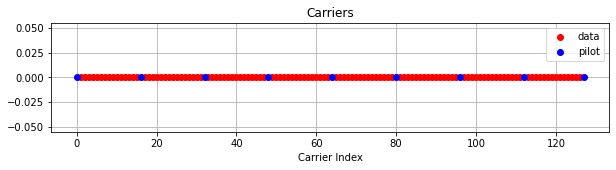

In [310]:
# Prints
print("All Carriers: \n", AllCarriers)
print("Pilot Carriers: \n", PilotCarriers)
print("Data Carriers: \n", DataCarriers)

# Plots
plt.figure(figsize=(10, 2))
plt.plot(DataCarriers, np.zeros_like(DataCarriers), 'ro', label='data')
plt.plot(PilotCarriers, np.zeros_like(PilotCarriers), 'bo', label='pilot')
plt.title('Carriers')
plt.xlabel('Carrier Index')
plt.legend()
plt.grid()

# Show Image
plt.show()

In [311]:
mu = 6                                       # bits per symbol (64-QAM)
payloadBits_per_OFDM = len(DataCarriers)*mu  # number of payload bits per OFDM symbol
print('payloadBits per OFDM: \n', payloadBits_per_OFDM)

# 64-QAM Modulation MAP
mapping_table = {
(0,0,0,0,0,0) : +7+7j, (0,0,0,0,0,1) : +5+7j,
(0,0,0,0,1,0) : +1+7j, (0,0,0,0,1,1) : +3+7j,
(0,0,0,1,0,0) : -7+7j, (0,0,0,1,0,1) : -5+7j,
(0,0,0,1,1,0) : -1+7j, (0,0,0,1,1,1) : -3+7j,
(0,0,1,0,0,0) : +7+5j, (0,0,1,0,0,1) : +5+5j,
(0,0,1,0,1,0) : +1+5j, (0,0,1,0,1,1) : +3+5j,
(0,0,1,1,0,0) : -7+5j, (0,0,1,1,0,1) : -5+5j,
(0,0,1,1,1,0) : -1+5j, (0,0,1,1,1,1) : -3+5j,
(0,1,0,0,0,0) : +7+1j, (0,1,0,0,0,1) : +5+1j,
(0,1,0,0,1,0) : +1+1j, (0,1,0,0,1,1) : +3+1j,
(0,1,0,1,0,0) : -7+1j, (0,1,0,1,0,1) : -5+1j,
(0,1,0,1,1,0) : -1+1j, (0,1,0,1,1,1) : -3+1j,
(0,1,1,0,0,0) : +7+3j, (0,1,1,0,0,1) : +5+3j,
(0,1,1,0,1,0) : +1+3j, (0,1,1,0,1,1) : +3+3j,
(0,1,1,1,0,0) : -7+3j, (0,1,1,1,0,1) : -5+3j,
(0,1,1,1,1,0) : -1+3j, (0,1,1,1,1,1) : -3+3j,
(1,0,0,0,0,0) : +7-7j, (1,0,0,0,0,1) : +5-7j,
(1,0,0,0,1,0) : +1-7j, (1,0,0,0,1,1) : +3-7j,
(1,0,0,1,0,0) : -7-7j, (1,0,0,1,0,1) : -5-7j,
(1,0,0,1,1,0) : -1-7j, (1,0,0,1,1,1) : -3-7j,
(1,0,1,0,0,0) : +7-5j, (1,0,1,0,0,1) : +5-5j,
(1,0,1,0,1,0) : +1-5j, (1,0,1,0,1,1) : +3-5j,
(1,0,1,1,0,0) : -7-5j, (1,0,1,1,0,1) : -5-5j,
(1,0,1,1,1,0) : -1-5j, (1,0,1,1,1,1) : -3-5j,
(1,1,0,0,0,0) : +7-1j, (1,1,0,0,0,1) : +5-1j,
(1,1,0,0,1,0) : +1-1j, (1,1,0,0,1,1) : +3-1j,
(1,1,0,1,0,0) : -7-1j, (1,1,0,1,0,1) : -5-1j,
(1,1,0,1,1,0) : -1-1j, (1,1,0,1,1,1) : -3-1j,
(1,1,1,0,0,0) : +7-3j, (1,1,1,0,0,1) : +5-3j,
(1,1,1,0,1,0) : +1-3j, (1,1,1,0,1,1) : +3-3j,
(1,1,1,1,0,0) : -7-3j, (1,1,1,1,0,1) : -5-3j,
(1,1,1,1,1,0) : -1-3j, (1,1,1,1,1,1) : -3-3j
}

payloadBits per OFDM: 
 714


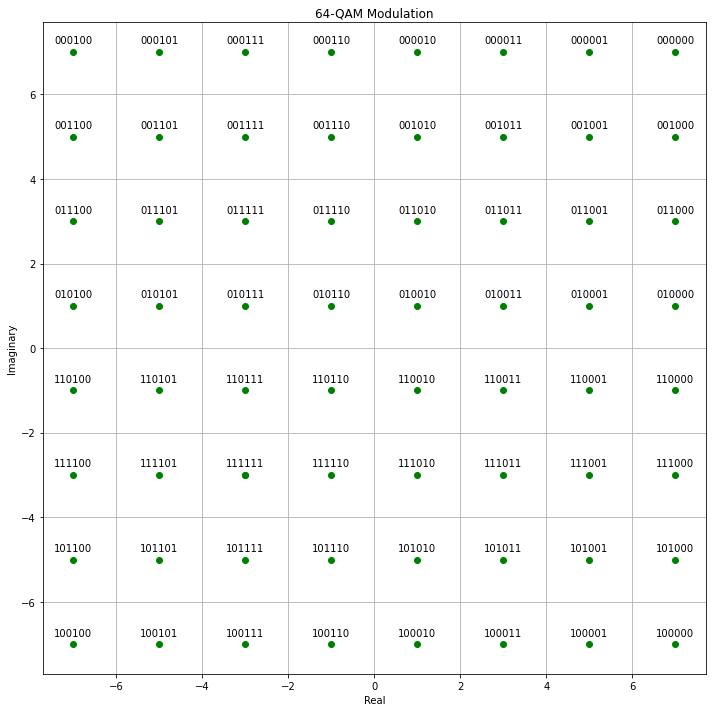

In [312]:
# Visualiza o mapa de constelação QAM

plt.figure(1, figsize=(10, 10))

for b5 in [0, 1]:
 for b4 in [0, 1]:
  for b3 in [0, 1]:
   for b2 in [0, 1]:
    for b1 in [0, 1]:
      for b0 in [0, 1]:
          B = (b5, b4, b3, b2, b1, b0)
          Q = mapping_table[B]
          plt.plot(Q.real, Q.imag, 'go')
          plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

plt.title('64-QAM Modulation')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.plot(Q.real, Q.imag, 'go')
plt.grid(True)
plt.tight_layout()
plt.show()

### Etapa 1: Agora iremos gerar um sinal OFDM de fato



In [313]:
# Gerando Bits conforme uma distribuição binomial de probabilidade 0.5.
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM))
print ("Bits count: \n", len(bits))
print ("First 20 bits: \n", bits[:64])
print ("Mean of bits (should be around 0.5): \n", np.mean(bits))

# Formata os dados para o formato do QAM
def SP(bits):
    return bits.reshape((len(DataCarriers), mu))

bits_SP = SP(bits)
print ("\n16 bit groups\n")
print (bits_SP[:16,:])

Bits count: 
 714
First 20 bits: 
 [0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0
 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1]
Mean of bits (should be around 0.5): 
 0.5042016806722689

16 bit groups

[[0 0 1 0 1 1]
 [1 0 1 0 0 0]
 [1 0 1 1 0 1]
 [1 1 0 1 0 1]
 [0 0 1 1 0 1]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [0 0 1 0 1 0]
 [0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [1 1 0 1 0 1]
 [0 0 1 0 1 0]
 [1 0 0 1 1 1]
 [0 0 1 0 1 1]
 [0 1 1 1 0 1]
 [1 0 1 1 0 0]]


In [314]:
# Realiza a modulação do sinal - > Bits to 64-QAM
def Mapping(bits):
  return np.array([mapping_table[tuple(b)] for b in bits])

# Realiza a demoulação do sinal
QAM = Mapping(bits_SP)
print ("First 16 QAM symbols and bits:")
print (bits_SP[:16,:], '\n')
print ("Conversão para números complexos: \n", QAM[:16])


First 16 QAM symbols and bits:
[[0 0 1 0 1 1]
 [1 0 1 0 0 0]
 [1 0 1 1 0 1]
 [1 1 0 1 0 1]
 [0 0 1 1 0 1]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [0 0 1 0 1 0]
 [0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [1 1 0 1 0 1]
 [0 0 1 0 1 0]
 [1 0 0 1 1 1]
 [0 0 1 0 1 1]
 [0 1 1 1 0 1]
 [1 0 1 1 0 0]] 

Conversão para números complexos: 
 [ 3.+5.j  7.-5.j -5.-5.j -5.-1.j -5.+5.j -1.-3.j  1.+1.j  1.+5.j  7.+1.j
  3.-5.j -5.-1.j  1.+5.j -3.-7.j  3.+5.j -5.+3.j -7.-5.j]


In [315]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(N_SC, dtype=complex) # The overall N_SC subcarriers
    symbol[PilotCarriers] = PilotValue     # Allocate the pilot subcarriers 
    symbol[DataCarriers] = QAM_payload     # Allocate the pilot subcarriers
    return symbol

OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print("First 20 OFDM symbols: \n", OFDM_data[:20])



Number of OFDM carriers in frequency domain:  128
First 20 OFDM symbols: 
 [ 7.+7.j  3.+5.j  7.-5.j -5.-5.j -5.-1.j -5.+5.j -1.-3.j  1.+1.j  1.+5.j
  7.+1.j  3.-5.j -5.-1.j  1.+5.j -3.-7.j  3.+5.j -5.+3.j  7.+7.j -7.-5.j
  7.-1.j  5.-5.j]


In [316]:
def IFFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

OFDM_time = IFFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))


# Add cyclic prefix
def addCP(OFDM_time):
    cp = OFDM_time[-CP_LEN:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])      # ... and add them to the beginning

OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))


Number of OFDM samples in time-domain before CP:  128
Number of OFDM samples in time domain with CP:  160


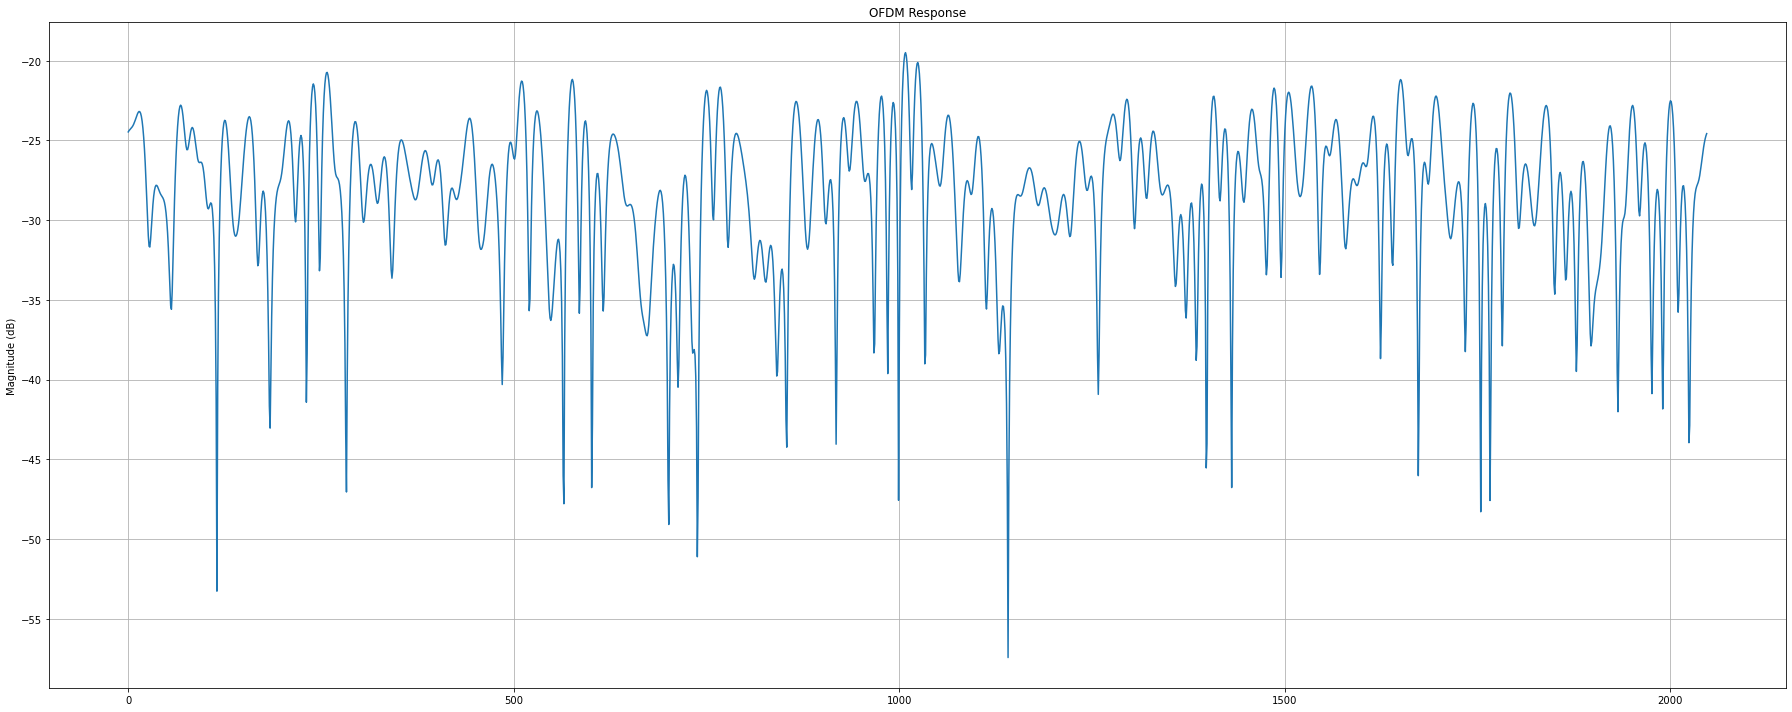

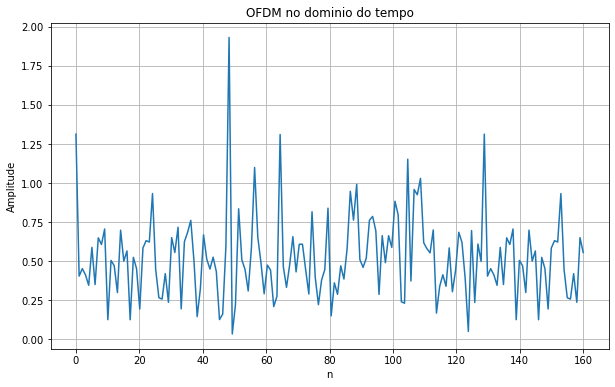

In [317]:
fftData = np.fft.fft(OFDM_withCP, 2048) / len(OFDM_withCP)
magData = np.abs(np.fft.fftshift(fftData))
with np.errstate(divide='ignore', invalid='ignore'):
    response = 20 * np.log10(magData)

# Realiza a Plotagem - Bart Plot
plt.figure(2, figsize=(25, 10))
plt.plot(response)
plt.title('OFDM Response')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.tight_layout()
plt.show()

#plotando no dominio do tempo
escala_amostras = np.linspace(0,160,len(OFDM_withCP))
plt.figure(3, figsize=(10, 6))
plt.plot(escala_amostras,np.abs(OFDM_withCP)) 
plt.title('OFDM no dominio do tempo')                             # Configuração do título do gráfico 
plt.xlabel('n')                               # Configuração do eixo x do gráfico 
plt.ylabel('Amplitude')                                 # Configuração do eixo y do gráfico  
plt.grid()                                             # Adiona o grid    
plt.show()

## Implementação dos filtros
![imagem_4.jpeg](imagens/imagem_4.jpeg)

#### Primeiro é preciso definir alguns parâmetros:
![imagem_2.jpeg](imagens/imagem_2.jpeg)
![imagem_3.jpeg](imagens/imagem_3.jpeg)

In [318]:
# Criando as janelas
janela_de_hamming = np.hamming(21)
janela_de_blackman = np.blackman(35)
janela_de_kaiser = np.kaiser(200,7.85)

# Filtro ideal
def h_indeal(f_corte:float, N:int)->np.ndarray:
    # Função que calcula o H_ideal (OBS: Divisão por zero!)
        return np.sin(f_corte*(np.arange(N) - N/(2.001)))/(np.pi*(np.arange(N) - N/2.0008))
    


### Filtro FIR Hamming

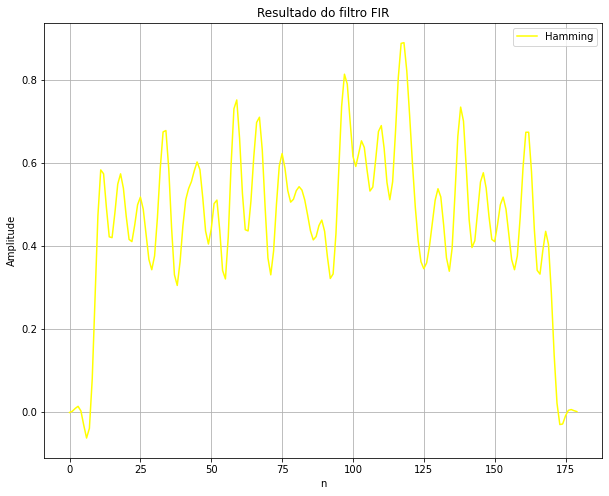

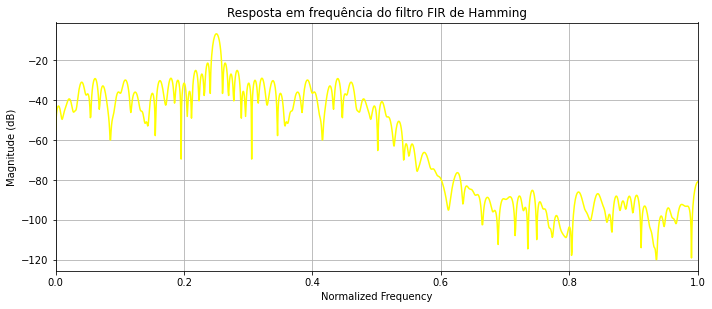

In [319]:
#Filtro FIR janela de Hamming    
def FIR_hamming():
    return h_indeal((0.3*np.pi), 21) * janela_de_hamming

#Filtrar o sinal OFDM
resultado_hamming = np.convolve(abs(OFDM_withCP), FIR_hamming())

#Plotando os sinais filtrado

hamming_freq = np.fft.fft(resultado_hamming, 2048) / len(resultado_hamming)

#Magnitude
magnitude_hamming = np.abs(np.fft.fftshift(hamming_freq))

# Normalizando 
with np.errstate(divide='ignore', invalid='ignore'):
    resposta_hamming = 20 * np.log10(magnitude_hamming)
    
# Clipando para excluir valores menores que 120 dB
resposta_hamming = np.clip(resposta_hamming, -120, 100)

# Plota o resultado do filtro FIR
plt.figure(4, figsize=(10, 8))
plt.plot(resultado_hamming, label='Hamming',color='yellow')
plt.title('Resultado do filtro FIR')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

#Espectro normalizado
plt.figure(5, figsize=(10, 8))
plt.subplot(2, 1, 2)
plt.plot(np.linspace(-.5, 1, len(resposta_hamming)), resposta_hamming, label='Hamming',color='yellow')
plt.title('Resposta em frequência do filtro FIR de Hamming')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()



### Filtro FIR Blackman

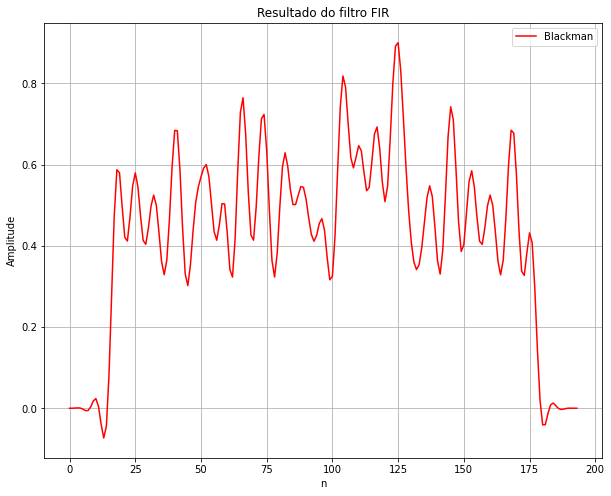

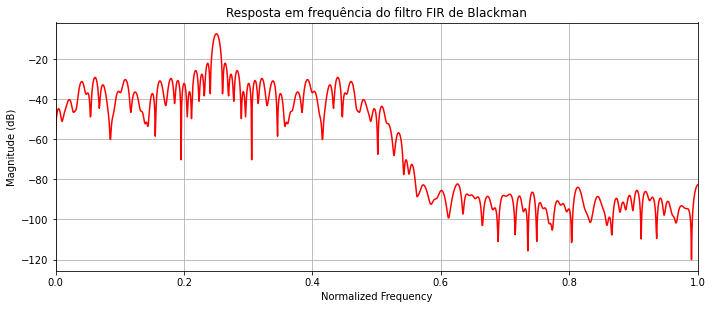

In [320]:
# Filtro FIR janela de Blackman
def FIR_blackman():
    return h_indeal((0.3*np.pi), 35) * janela_de_blackman

#Filtrar o sinal OFDM
resultado_blackman = np.convolve( abs(OFDM_withCP), FIR_blackman())

#Plotando os sinais filtrado
blackman_freq = np.fft.fft(resultado_blackman, 2048) / len(resultado_blackman)

#Magnitude
magnitude_blackman = np.abs(np.fft.fftshift(blackman_freq))

# Normalizando 
with np.errstate(divide='ignore', invalid='ignore'):
    resposta_blackman = 20 * np.log10(magnitude_blackman)
    
# Clipando para excluir valores menores que 120 dB
resposta_blackman = np.clip(resposta_blackman, -120, 100)

# Plota o resultado do filtro FIR
plt.figure(6, figsize=(10, 8))
plt.plot(resultado_blackman, label='Blackman',color='red')
plt.title('Resultado do filtro FIR')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

#Espectro normalizado
plt.figure(7, figsize=(10, 8))
plt.subplot(2, 1, 2)
plt.plot(np.linspace(-.5, 1, len(resposta_blackman)), resposta_blackman, label='Blackman',color='red')
plt.title('Resposta em frequência do filtro FIR de Blackman')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()

### Filtro FIR Kaiser

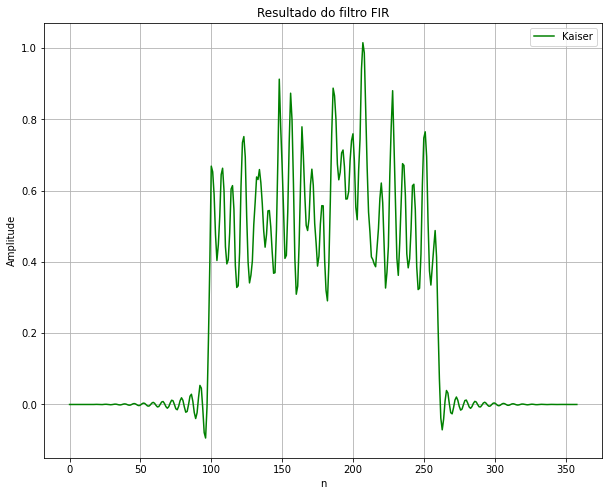

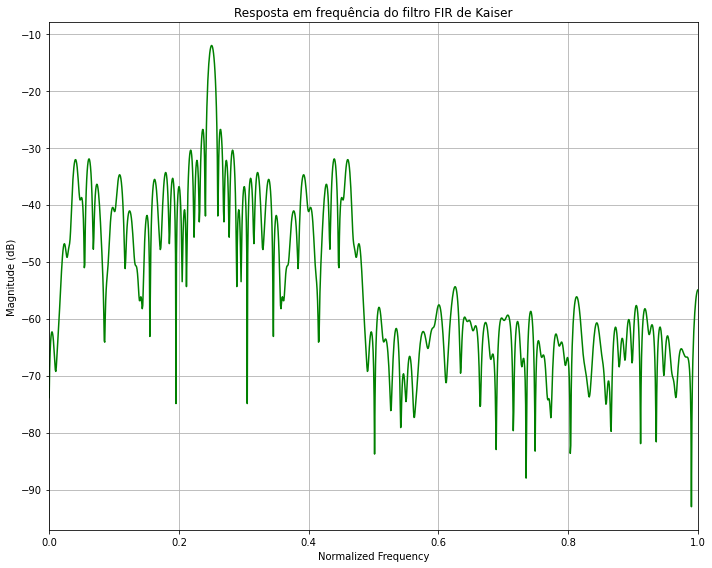

In [321]:
#Filtro FIR janela de Kaiser
def FIR_kaiser():
    return h_indeal((0.3*np.pi), 200) * janela_de_kaiser 

#Filtrar o sinal OFDM
resultado_kaiser = np.convolve(abs(OFDM_withCP), FIR_kaiser())

#Plotando os sinais filtrado
kaiser_freq = np.fft.fft(resultado_kaiser, 2048) / len(resultado_kaiser)

#Magnitude
magnitude_kaiser = np.abs(np.fft.fftshift(kaiser_freq))

# Normalizando 
with np.errstate(divide='ignore', invalid='ignore'):
    resposta_kaiser = 20 * np.log10(magnitude_kaiser)
    
# Clipando para excluir valores menores que 120 dB
resposta_kaiser = np.clip(resposta_kaiser, -120, 100)

# Plota o resultado do filtro FIR
plt.figure(8, figsize=(10, 8))
plt.plot(resultado_kaiser, label='Kaiser',color='green')
plt.title('Resultado do filtro FIR')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

#Espectro normalizado
plt.figure(9, figsize=(10, 8))

plt.plot(np.linspace(-.5, 1, len(resposta_kaiser)), resposta_kaiser, label='Kaiser', color='green')
plt.title('Resposta em frequência do filtro FIR de Kaiser')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()


### Visualizando os 3 filtros FIR e o sinal OFDM:

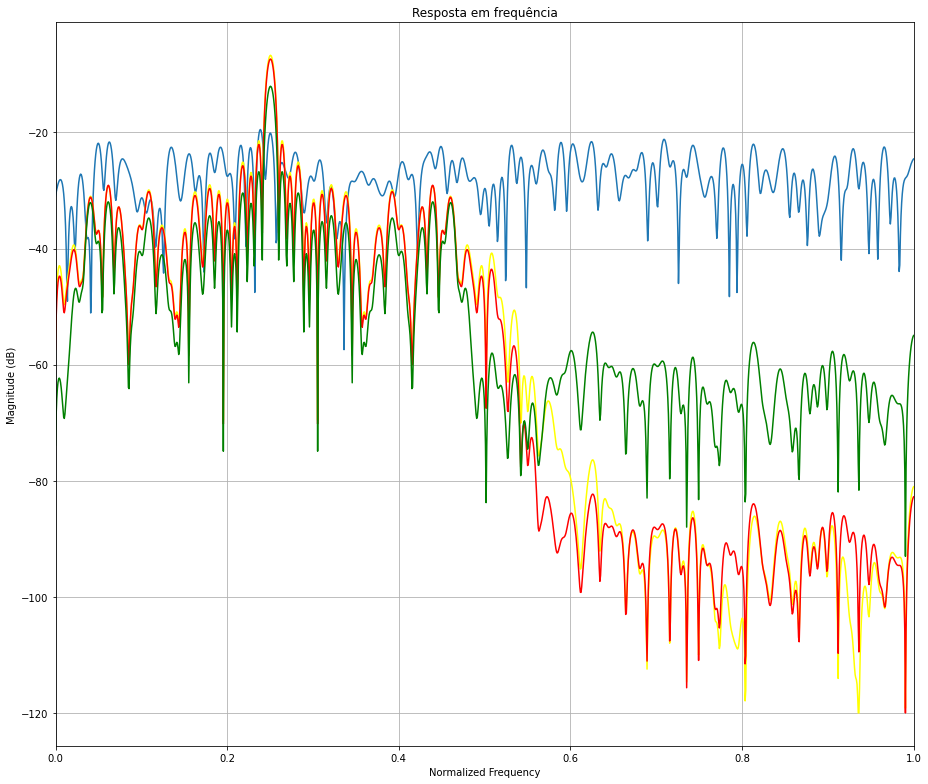

In [322]:
plt.figure(10, figsize=(13, 11))

plt.plot(np.linspace(-.5, 1, len(response)), response, label='OFDM')
plt.plot(np.linspace(-.5, 1, len(resposta_hamming)), resposta_hamming,label='Hamming',color='yellow')
plt.plot(np.linspace(-.5, 1, len(resposta_blackman)), resposta_blackman, label='Blackman',color='red')
plt.plot(np.linspace(-.5, 1, len(resposta_kaiser)), resposta_kaiser, label='Kaiser',color='green')
plt.title('Resposta em frequência')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()


## Referências bibliograficas:
https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html

https://numpy.org/

https://www.feis.unesp.br/Home/departamentos/engenhariaeletrica/ele1095_8b_filtrosfir.pdf
